In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ssm_kalman import run_ssm_kalman

In [2]:
# Load training and test data
X_train = np.loadtxt('ssm_spins.txt').T
X_test = np.loadtxt('ssm_spins_test.txt').T

In [3]:
# Define A
theta1 = 2 * np.pi / 180
theta2 = 2 * np.pi / 90
A_rotation = np.array([
    [np.cos(theta1), -np.sin(theta1), 0, 0],
    [np.sin(theta1), np.cos(theta1), 0, 0],
    [0, 0, np.cos(theta2), -np.sin(theta2)],
    [0, 0, np.sin(theta2), np.cos(theta2)]
])
A = 0.99 * A_rotation

# Define Q
Q = np.eye(4) - A @ A.T

# Define C
C = np.array([
    [1, 0, 1, 0],
    [0, 1, 0, 1],
    [1, 0, 0, 1],
    [0, 0, 1, 1],
    [0.5, 0.5, 0.5, 0.5]
])

# Define R
R = np.eye(5)


In [4]:
# Initial state and covariance
y_init = np.zeros(4)
Q_init = np.eye(4)

In [5]:
# Run the Kalman filter
Y_filt, V_filt, _, L_filt = run_ssm_kalman(X_train, y_init, Q_init, A, Q, C, R, mode='filt')

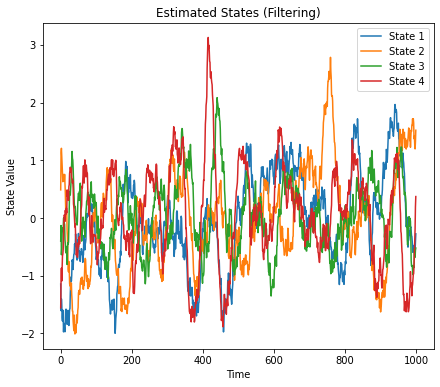

In [6]:
# Plot the estimated states
plt.figure(figsize=(7, 6))
for i in range(Y_filt.shape[0]):
    plt.plot(Y_filt[i, :], label=f'State {i+1}')
plt.title('Estimated States (Filtering)')
plt.xlabel('Time')
plt.ylabel('State Value')
plt.legend()
plt.savefig('Y_fit.png', dpi=300)
plt.show()

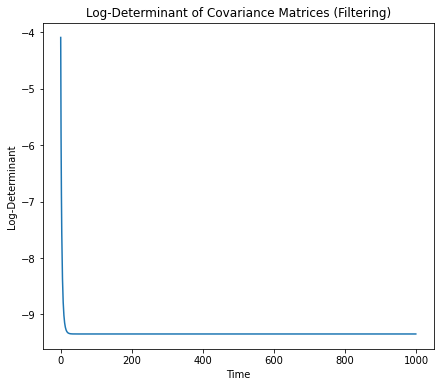

In [7]:
# Compute log-determinant of V_filt
logdet_V_filt = [np.linalg.slogdet(V_filt[t])[1] for t in range(V_filt.shape[0])]

plt.figure(figsize=(7, 6))
plt.plot(logdet_V_filt)
plt.title('Log-Determinant of Covariance Matrices (Filtering)')
plt.xlabel('Time')
plt.ylabel('Log-Determinant')
plt.savefig('V_fit.png', dpi=300)
plt.show()


In [8]:
# Run the Kalman smoother
Y_smooth, V_smooth, _, L_smooth = run_ssm_kalman(X_train, y_init, Q_init, A, Q, C, R, mode='smooth')


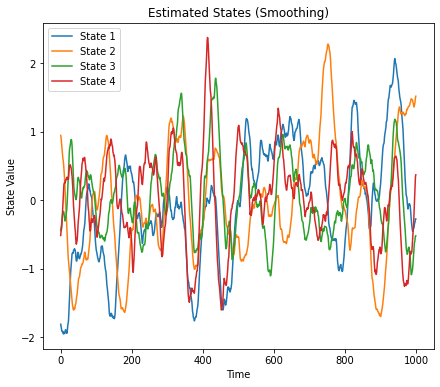

In [9]:
# Plot the estimated states
plt.figure(figsize=(7, 6))
for i in range(Y_smooth.shape[0]):
    plt.plot(Y_smooth[i, :], label=f'State {i+1}')
plt.title('Estimated States (Smoothing)')
plt.xlabel('Time')
plt.ylabel('State Value')
plt.legend()
plt.savefig('Y_smooth.png', dpi=300)
plt.show()


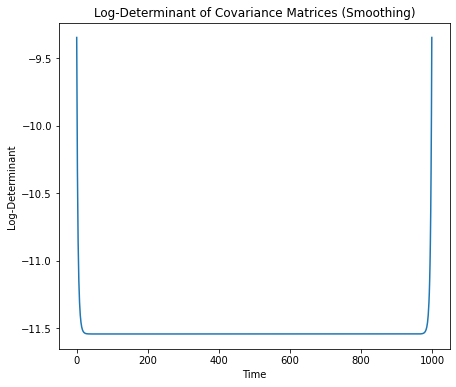

In [10]:
# Compute log-determinant of V_smooth
logdet_V_smooth = [np.linalg.slogdet(V_smooth[t])[1] for t in range(V_smooth.shape[0])]

plt.figure(figsize=(7, 6))
plt.plot(logdet_V_smooth)
plt.title('Log-Determinant of Covariance Matrices (Smoothing)')
plt.xlabel('Time')
plt.ylabel('Log-Determinant')
plt.savefig('V_smooth.png', dpi=300)
plt.show()


In [11]:
def em_algorithm(X, y_init, Q_init, A_init, Q_init_param, C_init, R_init, max_iters=50):
    """
    Run the EM algorithm to estimate parameters A, Q, C, R.
    """
    T = X.shape[1]
    k = A_init.shape[0]
    d = X.shape[0]

    # Initialize parameters
    A = A_init.copy()
    Q_param = Q_init_param.copy()
    C = C_init.copy()
    R = R_init.copy()

    log_likelihoods = []

    for iteration in range(max_iters):
        # E-step: Run Kalman smoother
        Y_smooth, V_smooth, V_joint, L = run_ssm_kalman(X, y_init, Q_init, A, Q_param, C, R, mode='smooth')
        total_log_likelihood = np.sum(L)
        log_likelihoods.append(total_log_likelihood)

        # Compute sufficient statistics

        # Sum over time of expected state outer products
        sum_y_yT = Y_smooth @ Y_smooth.T + np.sum(V_smooth, axis=0)

        # Sum over time of expected state at t and t-1 outer products
        sum_y_yPrevT = Y_smooth[:, 1:] @ Y_smooth[:, :-1].T + np.sum(V_joint[1:], axis=0)

        # Sum over time of expected previous state outer products
        sum_yPrev_yPrevT = Y_smooth[:, :-1] @ Y_smooth[:, :-1].T + np.sum(V_smooth[:-1], axis=0)

        # Sum over time of observations and state estimates
        sum_x_yT = X @ Y_smooth.T

        # Sum over time of observation outer products
        sum_x_xT = X @ X.T

        # Update C
        C_new = sum_x_yT @ np.linalg.inv(sum_y_yT)

        # Update R
        R_new = (sum_x_xT - C_new @ sum_x_yT.T) / T
        R_new = (R_new + R_new.T) / 2  # Ensure symmetry

        # Update A
        A_new = sum_y_yPrevT @ np.linalg.inv(sum_yPrev_yPrevT)

        # Update Q
        sum_y_yT_next = Y_smooth[:, 1:] @ Y_smooth[:, 1:].T + np.sum(V_smooth[1:], axis=0)
        Q_new = (sum_y_yT_next - A_new @ sum_y_yPrevT.T) / (T - 1)
        Q_new = (Q_new + Q_new.T) / 2  # Ensure symmetry

        # Update parameters
        A = A_new
        Q_param = Q_new
        C = C_new
        R = R_new

    return A, Q_param, C, R, log_likelihoods


In [23]:
# Initialize with true parameters
A_init = A.copy()
Q_init_param = Q.copy()
C_init = C.copy()
R_init = R.copy()

# Run EM
A_em_true, Q_em_true, C_em_true, R_em_true, ll_em_true = em_algorithm(
    X_train, y_init, Q_init, A_init, Q_init_param, C_init, R_init, max_iters=200
)


In [24]:
em_results_random = []

for i in range(10):
    # Random initialization
    A_init = np.random.randn(4, 4)
    Q_init_param = np.eye(4)
    C_init = np.random.randn(5, 4)
    R_init = np.eye(5)

    # Run EM
    A_em_rand, Q_em_rand, C_em_rand, R_em_rand, ll_em_rand = em_algorithm(
        X_train, y_init, Q_init, A_init, Q_init_param, C_init, R_init, max_iters=200
    )

    em_results_random.append({
        'A': A_em_rand,
        'Q': Q_em_rand,
        'C': C_em_rand,
        'R': R_em_rand,
        'log_likelihoods': ll_em_rand
    })

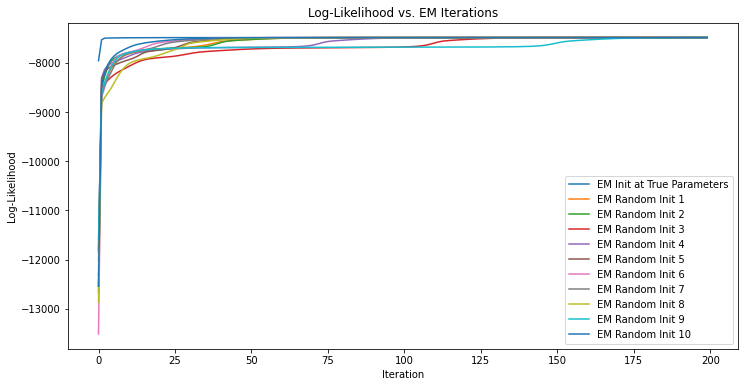

In [25]:
plt.figure(figsize=(12, 6))

# Plot for EM initialized at true parameters
plt.plot(ll_em_true, label='EM Init at True Parameters')

# Plot for EM runs with random initializations
for idx, result in enumerate(em_results_random):
    plt.plot(result['log_likelihoods'], label=f'EM Random Init {idx+1}')

plt.title('Log-Likelihood vs. EM Iterations')
plt.xlabel('Iteration')
plt.ylabel('Log-Likelihood')
plt.legend()
plt.savefig('runs.png', dpi=300)
plt.show()

                         Model  Training Log-Likelihood  Test Log-Likelihood
0              True Parameters             -7958.252479         -8031.964223
1   EM Init at True Parameters             -7486.158003         -7431.271450
2             EM Random Init 1             -7486.491128         -7440.906146
3             EM Random Init 2             -7485.265550         -7439.424476
4             EM Random Init 3             -7486.278643         -7435.145651
5             EM Random Init 4             -7486.516645         -7434.929224
6             EM Random Init 5             -7486.547517         -7442.206142
7             EM Random Init 6             -7485.077281         -7444.416476
8             EM Random Init 7             -7485.341470         -7435.895431
9             EM Random Init 8             -7485.794999         -7435.611981
10            EM Random Init 9             -7487.046042         -7440.961086
11           EM Random Init 10             -7487.279754         -7437.143238

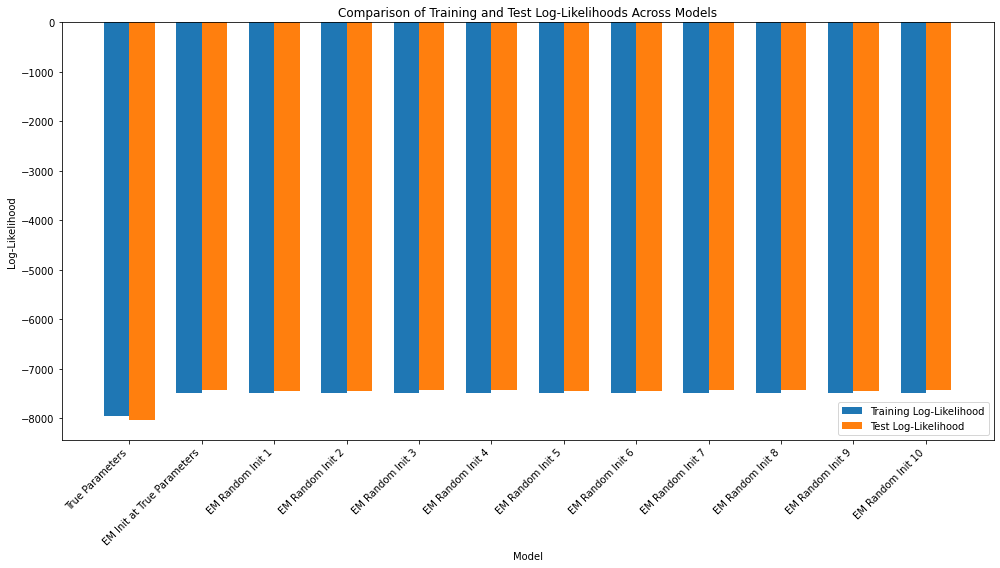

In [38]:
import pandas as pd

# Load the test data and transpose to match expected dimensions
X_test = np.loadtxt('ssm_spins_test.txt').T  # Shape: [d, T_test]

def compute_log_likelihood(X, y_init, Q_init, A, Q, C, R):
    _, _, _, likelihood = run_ssm_kalman(X, y_init, Q_init, A, Q, C, R, mode='filt')
    return np.sum(likelihood)

# Compute likelihood for True Parameters
ll_train_true = compute_log_likelihood(X_train, y_init, Q_init, A, Q, C, R)
ll_test_true = compute_log_likelihood(X_test, y_init, Q_init, A, Q, C, R)

# Compute likelihood for EM initialized at true parameters
ll_train_em_true = compute_log_likelihood(X_train, y_init, Q_init, A_em_true, Q_em_true, C_em_true, R_em_true)
ll_test_em_true = compute_log_likelihood(X_test, y_init, Q_init, A_em_true, Q_em_true, C_em_true, R_em_true)

# Compute likelihood for EM runs with random initializations
ll_train_em_random = []
ll_test_em_random = []

for result in em_results_random:
    A_em_rand = result['A']
    Q_em_rand = result['Q']
    C_em_rand = result['C']
    R_em_rand = result['R']
    
    ll_train = compute_log_likelihood(X_train, y_init, Q_init, A_em_rand, Q_em_rand, C_em_rand, R_em_rand)
    ll_test = compute_log_likelihood(X_test, y_init, Q_init, A_em_rand, Q_em_rand, C_em_rand, R_em_rand)
    
    ll_train_em_random.append(ll_train)
    ll_test_em_random.append(ll_test)

# If you have SSID parameters, include them similarly:
# ll_train_ssid = compute_log_likelihood(X_train, y_init, Q_init, A_ssid, Q_ssid, C_ssid, R_ssid)
# ll_test_ssid = compute_log_likelihood(X_test, y_init, Q_init, A_ssid, Q_ssid, C_ssid, R_ssid)

# Create a dictionary to store results
data = {
    'Model': ['True Parameters', 'EM Init at True Parameters'] + [f'EM Random Init {i+1}' for i in range(10)],
    'Training Log-Likelihood': [ll_train_true, ll_train_em_true] + ll_train_em_random,
    'Test Log-Likelihood': [ll_test_true, ll_test_em_true] + ll_test_em_random
}

# Create a DataFrame
results_df = pd.DataFrame(data)
print(results_df)

# Set up the figure
plt.figure(figsize=(14, 8))